In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from read_db.CH import Getch
import pandas as pd
from datetime import datetime, timedelta

sns.set(rc={'figure.figsize': (16, 10)}, style='whitegrid', font_scale=0.8)

In [2]:
query = """
SELECT toStartOfDay(toDateTime(time)) AS ts,
       source,
       os,
       country,
       gender,
       count(DISTINCT user_id) AS distinct_users
FROM simulator_20220320.feed_actions
WHERE ts < today()
GROUP BY ts,
       source,
       os,
       country,
       gender
ORDER BY distinct_users DESC
"""

In [3]:
df = Getch(query).df

In [4]:
df

,ts,source,os,country,gender,distinct_users
0,2022-04-10,organic,Android,Russia,1,3612
1,2022-04-09,organic,Android,Russia,1,3510
2,2022-04-08,organic,Android,Russia,1,3493
3,2022-04-07,organic,Android,Russia,1,3404
4,2022-04-03,organic,Android,Russia,1,3389
...,...,...,...,...,...,...
4267,2022-03-12,organic,iOS,Switzerland,0,1
4268,2022-02-21,organic,iOS,Latvia,0,1
4269,2022-04-03,ads,Android,Estonia,1,1
4270,2022-02-16,ads,Android,Kazakhstan,1,1


In [5]:
df_ts = df.groupby('ts', as_index=False).distinct_users.sum()

<AxesSubplot:xlabel='ts', ylabel='distinct_users'>

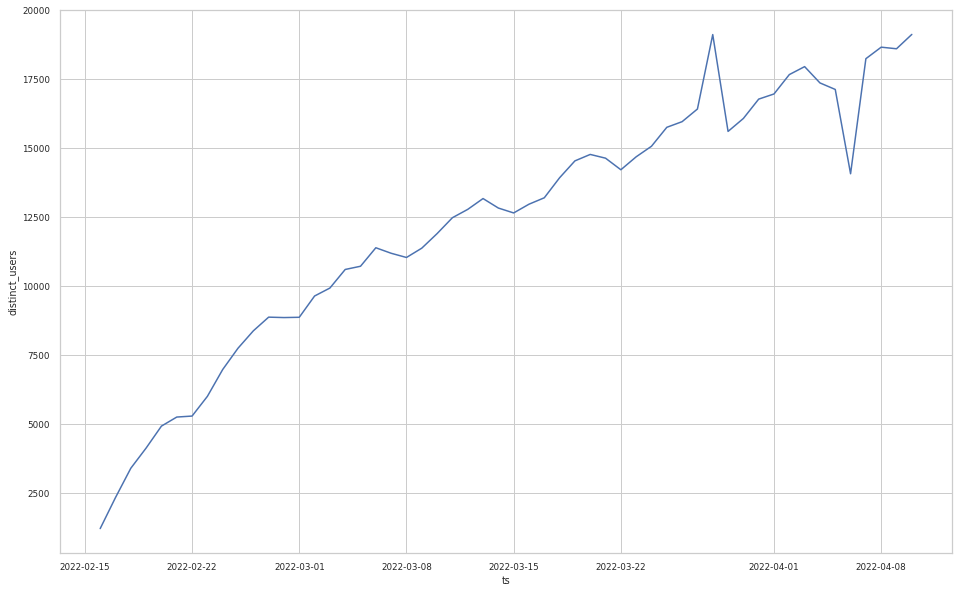

In [6]:
sns.lineplot(data=df_ts, x='ts', y='distinct_users')

Отчётливо видно "внезапное падение активной аудитории" 2022-04-06.

Что же случилось?

In [7]:
def check_metric(df, metric):
    df_metric = df.groupby(['ts', metric], as_index=False).agg({'distinct_users': 'sum'})
    plot = sns.lineplot(data=df_metric, x='ts', y='distinct_users', hue=metric)
    plot.set_xlabel('Day')
    plot.set_ylabel('Active users')

In [8]:
metrics = df.columns.tolist()[1:-1]
metrics

['source', 'os', 'country', 'gender']

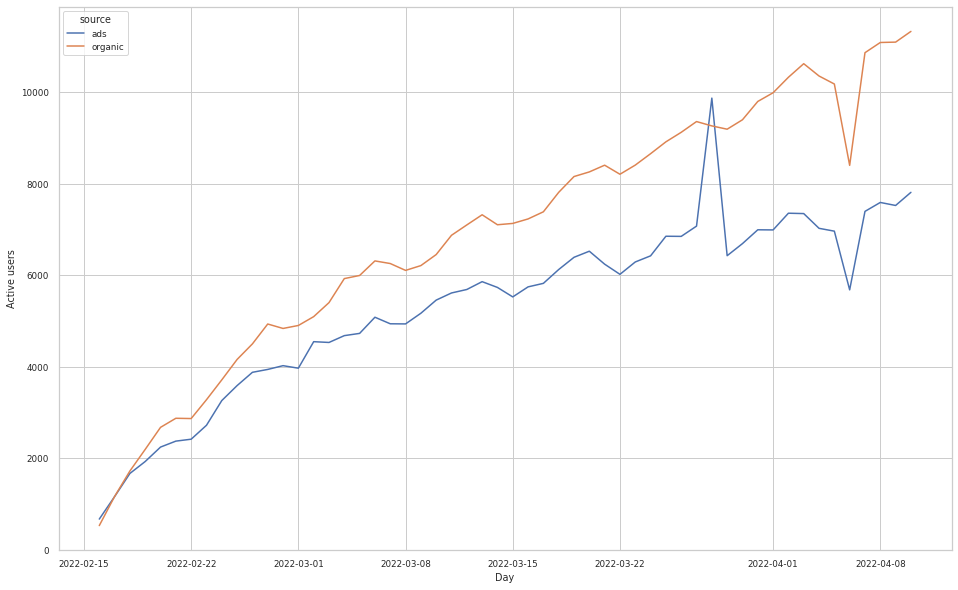

In [9]:
check_metric(df, metrics[0])

В данных по обоим источникам пользователей разницы в падении 2022-04-06 нет.

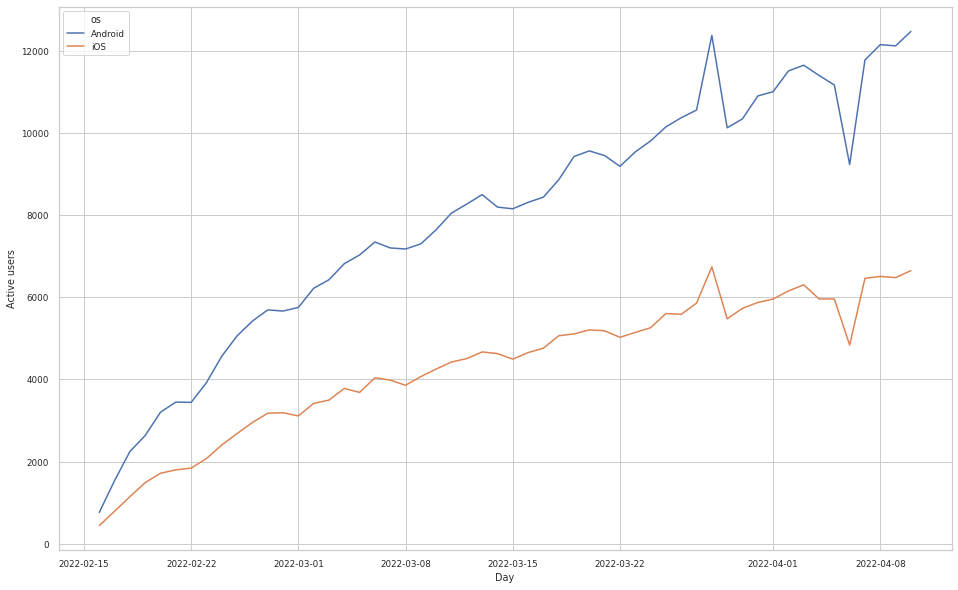

In [10]:
check_metric(df, metrics[1])

В данных по обоим операционным системам разницы в падении 2022-04-06 нет.

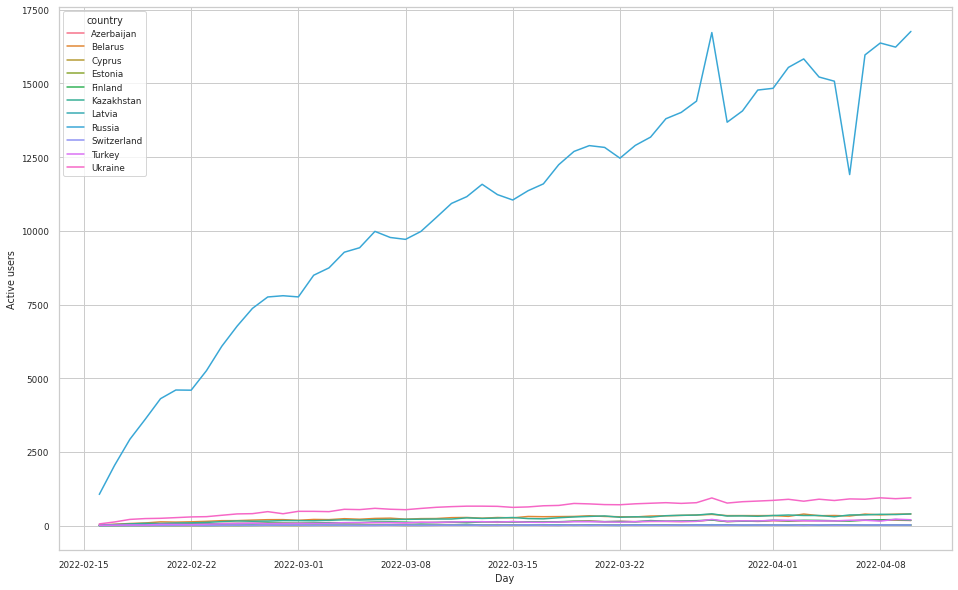

In [11]:
check_metric(df, metrics[2])

Разница по странам есть.

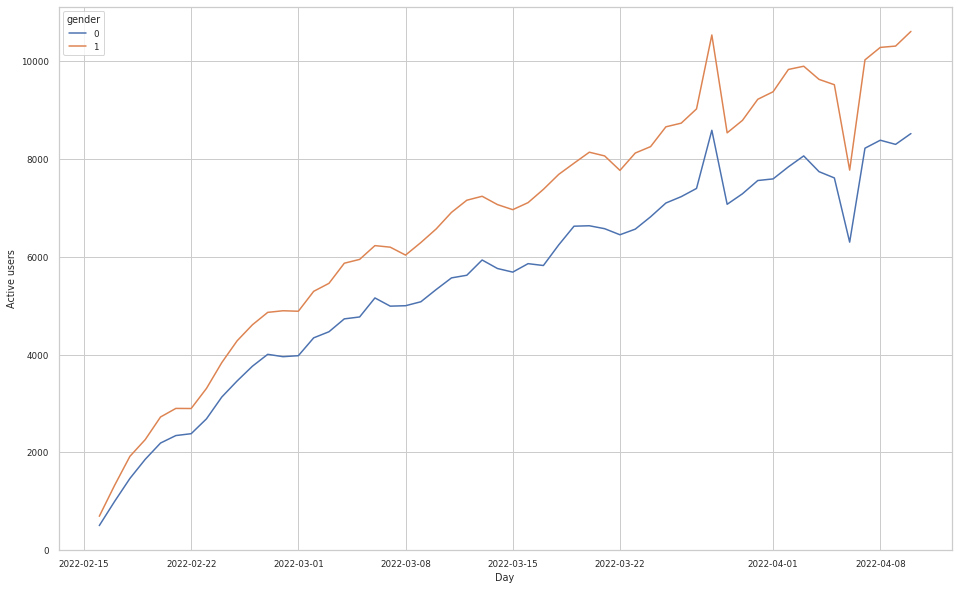

In [12]:
check_metric(df, metrics[3])

В данных по обоим полам разницы в падении 2022-04-06 нет.

Вернёмся к данным по странам:

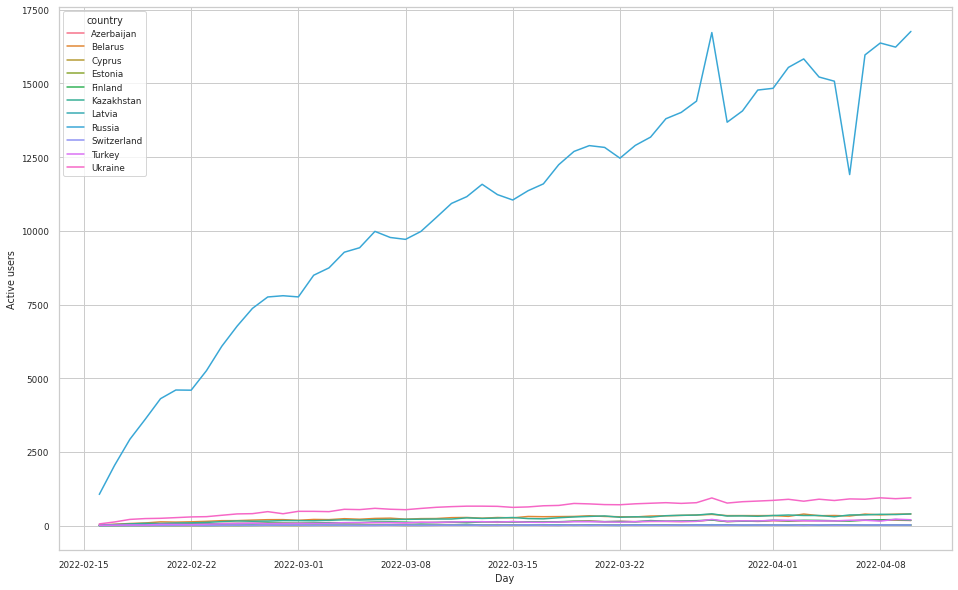

In [13]:
check_metric(df, 'country')

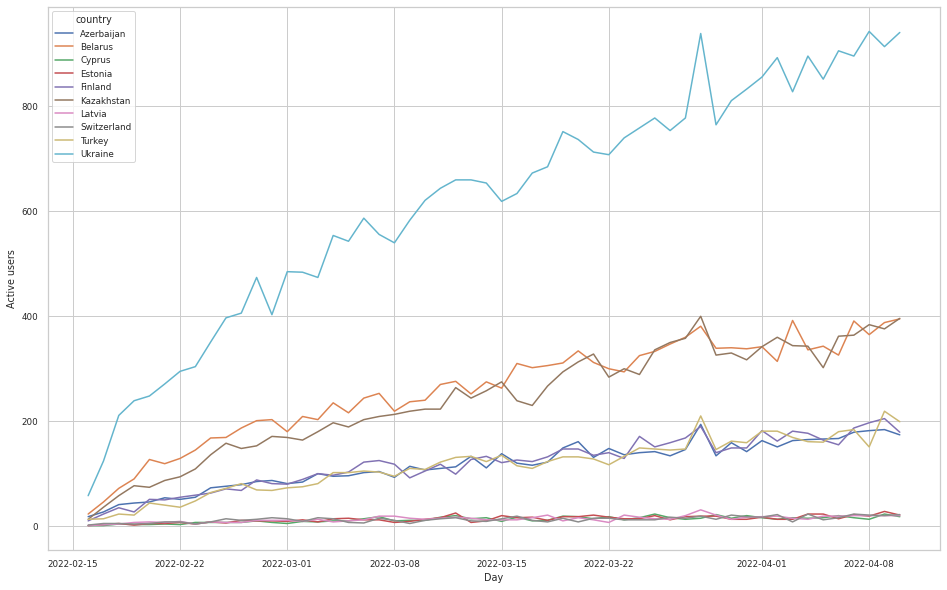

In [ ]:
check_metric(df[df.country != 'Russia'], 'country')

У данных по странам кроме России значения колеблются рядом с некоторым трендом, падение незаметно.

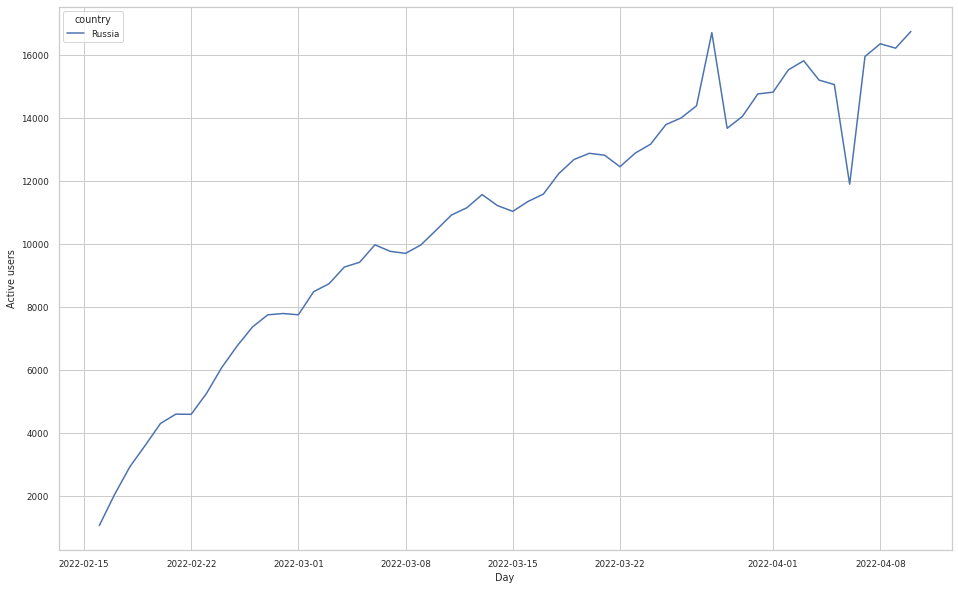

In [ ]:
check_metric(df[df.country == 'Russia'], 'country')

В данных по России падение заметно и, видимо, падение аудитории из России отвечает за "внезапное падение активной аудитории".

Проверим это предположение:

In [ ]:
df_ru = (
    df.groupby(['country','ts'], as_index=False)
    .agg({'distinct_users': 'sum'})
    .query('country == "Russia"')
    .drop('country', axis=1)
    .set_index('ts')
)
df_ru.distinct_users.astype(int).diff()['2022-04-06']

-3167.0

In [ ]:
df_ts = (
    df.groupby('ts', as_index=True).agg({'distinct_users': 'sum'})
)
df_ts.distinct_users.astype(int).diff()['2022-04-06']

-3059.0

In [ ]:
df_not_ru = (
    df.groupby(['country','ts'], as_index=False)
    .agg({'distinct_users': 'sum'})
    .query('country != "Russia"')
    .drop('country', axis=1)
    .set_index('ts')
)
df_not_ru.distinct_users.astype(int).diff()['2022-04-06'].sum()

108.0

Судя по всему, это так и даже более того: абсолютное значение падения аудитории из РФ оказалось больше, чем общее падение аудитории, так как остальные страны дали прирост (которого всё ещё не хватило для того, чтобы отыграть потери).

Ответ: "внезапное падение активной аудитории" вызвано тем, что пользователи из РФ по какой-то причине (отключение интернета, падение выделенного для них сервера, проблемы российских провайдеров, полная блокировка приложения на территории РФ) не смогли подключиться.